Para poder disponer de una línea base vamos a uilizar el modelo Arisa para predecir, y en base a lo conseguido podemos dictaminar que es lo mínimo que podemos conseguir.

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 25.4 MB/s eta 0:00:00


In [ ]:
import pickle
import statsmodels.api as sm
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima



In [ ]:



with open('/content/gdrive/MyDrive/PatronesComportamiento/trainingX.pkl', 'rb') as file:
        X_train=pickle.load(file)
with open('/content/gdrive/MyDrive/PatronesComportamiento/trainingy.pkl', 'rb') as file:
        y_train=pickle.load(file)
with open('/content/gdrive/MyDrive/PatronesComportamiento/testX.pkl', 'rb') as file:
        X_test=pickle.load(file)
with open('/content/gdrive/MyDrive/PatronesComportamiento/testy.pkl', 'rb') as file:
        y_test=pickle.load(file)
with open('/content/gdrive/MyDrive/PatronesComportamiento/validateX.pkl', 'rb') as file:
        X_val=pickle.load(file)
with open('/content/gdrive/MyDrive/PatronesComportamiento/validatey.pkl', 'rb') as file:
        y_val=pickle.load(file)


with open('/content/gdrive/MyDrive/PatronesComportamiento/mySeriesInten.pkl', 'rb') as file:
        mySeries=pickle.load(file)


8
----                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  287
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -317.115
Date:                Thu, 27 Apr 2023   AIC                            642.231
Time:                        15:25:23   BIC                            656.855
Sample:                             0   HQIC                           648.093
                                - 287                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9370      0.040     23.317      0.000       0.858       1.016
ma.L1         -0.9614      0.067    -14.408      0.000      -1.092      -0.831
ma.L2          0.1315      0.057      2.310  

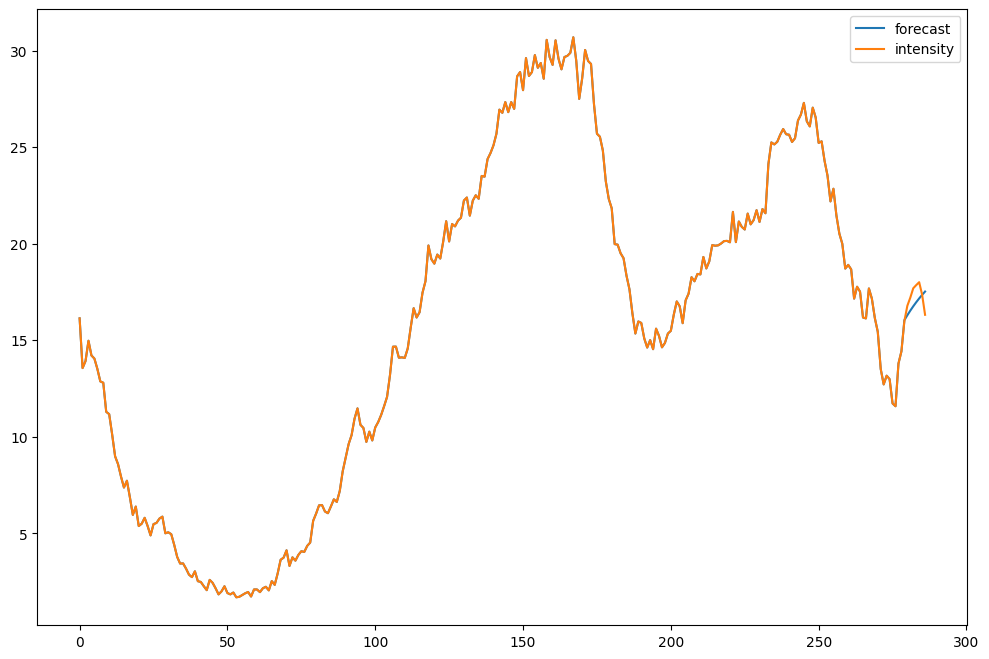

In [ ]:
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)
start=280
end=287
arima_model= ARIMA(mySeries[7],order=(1,1,2))
model=arima_model.fit()
#model.plot_predict(dynamic=False)
df=pd.DataFrame()
array_of_zeros=np.zeros(287-14)
df['intensity']=np.array(mySeries[7])
intent=np.array(mySeries[7][:end-(end-start+1)])
forecast = model.predict(start=start,end=end,dynamic=True)
print(len(forecast))
df['forecast'] = np.concatenate((intent, forecast))
df[['forecast','intensity']].plot(figsize=(12,8))


print("----",model.summary())

Ahra vamos a predecir para distintas ventanas. Para este modelo vamos a entrenarlo con las series de entrenamiento y posteriormente calcular para las series de validación sus erorres.

In [ ]:
with open('/content/gdrive/MyDrive/PatronesComportamiento/singleSerieIntenTrT.pkl', 'rb') as file:
    singleSerieTrT = pickle.load(file)


with open('/content/gdrive/MyDrive/PatronesComportamiento/singleSerieIntenValit.pkl', 'rb') as file:
    singleSerieValit= pickle.load(file)


    
with open('/content/gdrive/MyDrive/PatronesComportamiento/singleSerieInten.pkl', 'rb') as file:
        singleSerie=pickle.load(file)

In [ ]:
def spliting_timeseries(timeSerie,w,h):  #w amplitud de la ventana y h >1 si es multiobjetivo
  X, y = [], []  #inicializamos los arrays que guardarán atributos y variable predicha
  for i in range(len(timeSerie) - w): #bucle para iterar sobre todas las muestras de las series 
    X.append(timeSerie[i : i + w+h])  #cogemos desde el elemento en el que estamos hasta los w siguientes
    y.append(timeSerie[i + w:i+w+h])  #aquí cogemos desde el w+1 hasta los h siguientes
  return pd.DataFrame(X), pd.Series(y),X,y

In [49]:
from sklearn.metrics import mean_squared_error

sizes=[10,20,30,40,50,70,90,110,140,170,200,230,260,288]
metrics=[]
h=1
for w in sizes:
  print("Ventana de tamaño ", w)
  data_x,data_y,x,y=spliting_timeseries(singleSerieValit,w,h)
  error=[]
  for j in range(len(x)):
    print("========================================================================")
    start=w
    end=w+h
    #arima_model=  ARIMA(x[j],order=(1,1,2))
    model = auto_arima(x[j], start_p=1, start_q=1,
                   max_p=5, max_q=5, m=12,
                   start_P=0, seasonal=True,
                   d=None, D=0, trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)

  # Ajustar el modelo ARIMA con los mejores parámetros
    orders=model.to_dict()['order']
    arima_model=  ARIMA(x[j],order=orders)

    model=arima_model.fit()
    df=pd.DataFrame()
    intent=np.array(x[j][:end-(end-start+1)])
    forecast = model.predict(start=start,end=end-1,dynamic=True)
    error.append(forecast)
  print("&%$=================&&&&&&&&&%%%%%%%%%%$")
  print(forecast)
  
  metrics.append([w,h,mean_squared_error(y[j],error)])
dfMetrics = pd.DataFrame(np.array(metrics),
                   columns=['w','h','mean'])

  

Ventana de tamaño  10
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.83 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=35.560, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=38.405, Time=0.21 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=38.501, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=109.494, Time=0.02 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=37.560, Time=0.17 sec


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=37.560, Time=0.03 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=39.560, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=36.405, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=36.501, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=38.327, Time=0.11 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.868 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=35.805, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=36.140, Time=0.54 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=36.832, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=109.633, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=37.805, Time=0.06 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=37.805, Time=0.01 sec


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=39.805, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=34.293, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=35.909, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=36.115, Time=0.20 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=34.832, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=38.388, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[12]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 2.427 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=35.811, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=35.850, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=109.63

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=33.861, Time=0.07 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=34.902, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=35.235, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=35.132, Time=0.23 sec
 ARIMA(1,0,0)(0,0,0)[12]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 1.911 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=39.921, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=38.962, Time=0.22 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=109.765, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=37.245, 

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=41.490, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=109.997, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=43.490, Time=0.06 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=43.490, Time=0.01 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=45.490, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=35.794, Time=0.11 sec


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=38.866, Time=0.28 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=36.683, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[12]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 2.027 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=32.544, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=31.842, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=34.544, Time=0.01 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=34.544, Time=0.

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 1.201 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=32.238, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=31.099, Time=0.03 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=34.238, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=34.238, Time=0.03 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=36.238, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=32.014, Time=0.04 sec


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.40 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 2.427 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=33.978, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=35.923, Time=0.32 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=36.135, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=110.662, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=35.978, Time=0.11 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=35.978, Time=0.10 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=37.978, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=33.949, Time=0.13 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.74 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=35.91

KeyboardInterrupt: ignored

In [48]:
len(error)

4698

In [ ]:

with open('/content/gdrive/MyDrive/PatronesComportamiento/dftMetricsArima.pkl', 'wb') as file:
    pickle.dump(dfMetrics,file)


In [40]:
from sklearn.metrics import mean_squared_error

wh=[[144,144],[288,288],[288,144]]
metrics=[]
h=1
for v in wh:
  print("Ventana de tamaño ", w)
  data_x,data_y,x,y=spliting_timeseries(singleSerieValit,v[0],v[1])
  error=[]
  for j in range(1):
    start=v[0]
    end=v[0]+v[1]
    #arima_model=  ARIMA(x[j],order=(1,1,2))
    model = auto_arima(x[j], start_p=1, start_q=1,
                   max_p=5, max_q=5, m=12,
                   start_P=0, seasonal=True,
                   d=None, D=0, trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)

  # Ajustar el modelo ARIMA con los mejores parámetros
    orders=model.to_dict()['order']
    arima_model=  ARIMA(x[j],order=orders)

    model=arima_model.fit()
    df=pd.DataFrame()
    intent=np.array(x[j][:end-(end-start+1)])
    forecast = model.predict(start=start,end=end-1,dynamic=True)
    error.append(forecast)
    print()
    
  metrics.append([v[0],v[1],mean_squared_error(y[j],error)])
dfMetricsWideh = pd.DataFrame(np.array(metrics),
                   columns=['w','h','mean'])

  

Ventana de tamaño  288
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=754.173, Time=0.99 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=820.364, Time=0.12 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=762.712, Time=0.26 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=765.520, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=818.619, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=790.691, Time=0.15 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=753.519, Time=0.85 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=752.562, Time=0.45 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=753.342, Time=2.09 sec
 ARIMA(1,1,1)(2,0,1)[12] intercept   : AIC=755.331, Time=3.59 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=765.767, Time=0.18 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=754.160, Time=0.62 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=754.155, Time=0.44 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=771.666, Time=0.15 sec
 ARIMA(0,1

ValueError: ignored

In [ ]:
from statsmodels.tsa.stattools import acf
import pandas as pd
import matplotlib.pyplot as plt


my_index =[i for i in range(287)]

n=9

# Create Training and Test
train = mySeries[n][:267]
test = mySeries[n][267:]

train = pd.Series(train, index=my_index[:267])
test = pd.Series(test, index=my_index[267:])

model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  
fc, se, conf = fitted.forecast(20, alpha=0.05)  # 95% conf
print(test)
print(test.index)

fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()


NotImplementedError: ignored